# Inverse perspective mapping

## Setting up Colab

In [ ]:
colab_nb = 'google.colab' in str(get_ipython())

In [ ]:
if colab_nb:
  from google.colab import drive
  drive.mount('/content/drive')

In [ ]:
if colab_nb:
  %cd /content/drive/My Drive/aad/code/tests/lane_detection

In [76]:
import numpy as np
n=np.array([0, 1, 0]).T
t=np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
h=9

#h*t@n


#np.vstack(((np.vstack((t.T,n)).T),np.array([0 ,0, 0,1])))

np.hstack((n,[1]))

array([0, 1, 0, 1])

## Exercise

Solve the TODO items in `exercises/lane_detection/camera_geometry.py` which are labeled as **"TODO step 2"**.

The cells below will help you check if your implementation is correct. You might want to read them before you start with your implementation.

### Unit test

In [81]:
# execute this cell to run unit tests on your implementation of step 2
%cd ../../../
!python -m code.tests.lane_detection.camera_geometry_unit_test 2
%cd -

/var/Algorithms-for-Automated-Driving-master
-------------------------
Running tests for step  2
-------------------------
It seems that you computed rotation_cam_to_road correctly!
It seems that you computed translation_cam_to_road correctly!
It seems that you computed trafo_cam_to_road correctly!
It seems that you computed road_normal_camframe correctly!
0.6722626168144518
1.9337680952127185
[-0.68209558  1.135783    1.9337681   1.        ]
[-0.68209558  0.          1.82741951  1.        ]
Your function uv_to_roadXYZ_camframe() worked correctkly for u,v=76,982!
0.45385495445618584
2.86435123652594
[-0.15757581  1.05436753  2.86435124  1.        ]
[-0.15757581  0.          2.76155733  1.        ]
Your function uv_to_roadXYZ_camframe() worked correctkly for u,v=444,711!
0.7044999101514652
1.8452805760053317
[-0.76135454  1.14352466  1.84528058  1.        ]
[-0.76135454  0.          1.73859399  1.        ]
Your function uv_to_roadXYZ_camframe() worked correctkly for u,v=2,1022!
/var/Alg

### Test by visual inspection

When you change the boolean below to `True`, your code will be run. Otherwise the sample solution will be run. The images that the code generates should be the same for your code and the sample solution.

In [90]:
run_student_code = True

In [91]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.append(str(Path('../../')))
if run_student_code:
    from exercises.lane_detection import camera_geometry
else:
    from solutions.lane_detection import camera_geometry

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

First we construct the pixel coordinates $(u,v)$ for the left lane boundary, in the same way that we did it in the chapter on image formation:

(60, 3)
[[-7.71380796e+03  5.88844251e+03  2.80988548e-01]
 [-1.40353610e+03  1.42277625e+03  1.26520879e+00]
 [-6.13960704e+02  8.64869600e+02  2.24966659e+00]
 [-3.04185082e+02  6.46584900e+02  3.23430781e+00]
 [-1.38314512e+02  5.30172118e+02  4.21913683e+00]
 [-3.46917937e+01  4.57809662e+02  5.20414967e+00]
 [ 3.66042090e+01  4.08295433e+02  6.19355707e+00]
 [ 8.84551930e+01  3.72310576e+02  7.18652194e+00]
 [ 1.27717073e+02  3.45062624e+02  8.17948681e+00]
 [ 1.58478354e+02  3.23714133e+02  9.17245168e+00]
 [ 1.83230068e+02  3.06536312e+02  1.01654166e+01]
 [ 2.03524179e+02  2.92520094e+02  1.11503322e+01]
 [ 2.20789546e+02  2.80798881e+02  1.21334360e+01]
 [ 2.35744834e+02  2.70832776e+02  1.31167463e+01]
 [ 2.48869420e+02  2.62254699e+02  1.41003038e+01]
 [ 2.60521257e+02  2.54794282e+02  1.50840056e+01]
 [ 2.70972480e+02  2.48245983e+02  1.60679265e+01]
 [ 2.80428201e+02  2.42452315e+02  1.70520397e+01]
 [ 2.89053935e+02  2.37290120e+02  1.80363082e+01]
 [ 2.96975591e+02  2.32

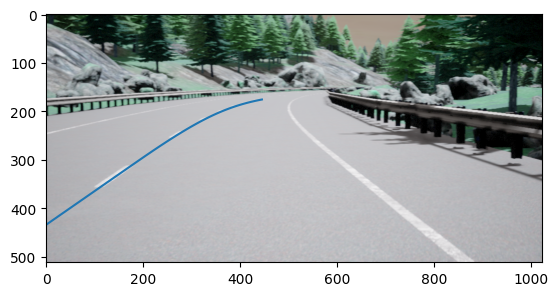

In [93]:
image_fn = str(Path("../../../data/Town04_Clear_Noon_09_09_2020_14_57_22_frame_625_validation_set.png").absolute())
image = cv2.imread(image_fn)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

boundary_fn = image_fn.replace(".png", "_boundary.txt")
boundary_gt = np.loadtxt(boundary_fn)

trafo_fn = image_fn.replace(".png", "_trafo.txt")
trafo_world_to_cam = np.loadtxt(trafo_fn)

cg = camera_geometry.CameraGeometry()
K = cg.intrinsic_matrix

left_boundary_3d_gt_world = boundary_gt[:,0:3]
uv = camera_geometry.project_polyline(left_boundary_3d_gt_world, trafo_world_to_cam, K)
u,v = uv[:,0], uv[:,1]
plt.plot(u,v)
plt.imshow(image);

Now we have image coordinates $(u,v)$ in our numpy array `uv`. Let us try to reconstruct the 3d coordinates using equation

$$
    \begin{pmatrix} X_c \\ Y_c \\Z_c \end{pmatrix} = \frac{h}{ \mathbf{n_c}^T \mathbf{K}^{-1} (u,v,1)^T} \mathbf{K}^{-1} \begin{pmatrix} u \\ v \\ 1 \end{pmatrix} 
$$ 

The relevant code is implemented in camera_geometry.py in the function `uv_to_roadXYZ_camframe()`.

In [94]:
# Reconstruct the left boundary starting from the known u,v
reconstructed_lb_3d_cam = []
for u,v in uv:
    xyz = cg.uv_to_roadXYZ_camframe(u,v)
    reconstructed_lb_3d_cam.append(xyz)
reconstructed_lb_3d_cam = np.array(reconstructed_lb_3d_cam)

4.626523278636002
0.28098853538747737
[-1.86991352  1.28038248  0.28098854  1.        ]
[-1.86991352  0.          0.1683266   1.        ]
1.0274984485705716
1.265208722999558
[-1.96068069  1.19427437  1.26520872  1.        ]
[-1.96068069  0.          1.15630635  1.        ]
0.5778634406210745
2.249666458571578
[-2.04925367  1.10814548  2.24966646  1.        ]
[-2.04925367  0.          2.14452456  1.        ]
0.40194074240748057
3.2343076051794784
[-2.13562172  1.02200054  3.23430761  1.        ]
[-2.13562172  0.          3.13292687  1.        ]
0.30811991727495813
4.219136534558764
[-2.21973627  0.93583917  4.21913653  1.        ]
[-2.21973627  0.          4.12151769  1.        ]
0.2498006746146618
5.204149276239376
[-2.30168906  0.84966172  5.20414928  1.        ]
[-2.30168906e+00  2.22044605e-16  5.11029302e+00  1.00000000e+00]
0.2098955560876383
6.19355656799712
[-2.38204408  0.7630998   6.19355657  1.        ]
[-2.38204408e+00  2.22044605e-16  6.10347969e+00  1.00000000e+00]
0.1808

In [95]:
# Map reconstructed left boundary into world reference frame
def map_between_frames(points, trafo_matrix):
    x,y,z = points[:,0], points[:,1], points[:,2]
    homvec = np.stack((x,y,z,np.ones_like(x)))
    return (trafo_matrix @ homvec).T

trafo_cam_to_world = np.linalg.inv(trafo_world_to_cam)
reconstructed_lb_3d_world = map_between_frames(reconstructed_lb_3d_cam, trafo_cam_to_world)

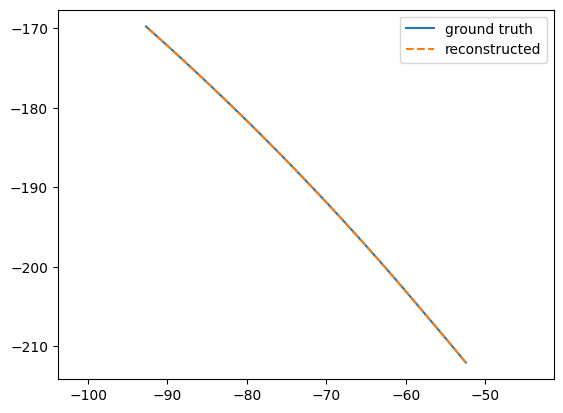

In [96]:
# plot both ground truth and reconstructed left boundary 3d in X-Y-plane
plt.plot(left_boundary_3d_gt_world[:,0], left_boundary_3d_gt_world[:,1], label="ground truth")
plt.plot(reconstructed_lb_3d_world[:,0], reconstructed_lb_3d_world[:,1], ls = "--", label="reconstructed")
plt.axis("equal")
plt.legend();

You should see that the lines overlap. Finally, we can also do this comparison in the road frame instead of the world frame.

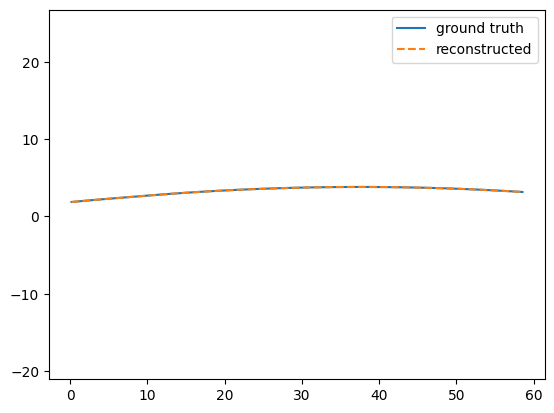

In [97]:
# compare ground truth and reconstructed boundary in road frame
trafo_world_to_road = cg.trafo_cam_to_road @ trafo_world_to_cam
left_boundary_3d_gt_road = map_between_frames(left_boundary_3d_gt_world, trafo_world_to_road)
reconstructed_lb_3d_road = map_between_frames(reconstructed_lb_3d_cam, cg.trafo_cam_to_road)

# plot both ground truth and reconstructed left boundary 3d in Z-(-X)-plane (which is X-Y in road iso 8855)
plt.plot(left_boundary_3d_gt_road[:,2], -left_boundary_3d_gt_road[:,0], label="ground truth")
plt.plot(reconstructed_lb_3d_road[:,2], -reconstructed_lb_3d_road[:,0], ls = "--", label="reconstructed")
plt.axis("equal")
plt.legend();

You should see that the lines overlap.